## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 17: Convnets in Practice - Notebook 4: Filter Visualization 2

Activation code based on https://github.com/fchollet/deep-learning-with-python-notebooks

In [1]:
import keras
from keras.applications import VGG16
from keras.preprocessing import image
from keras import models
from keras import backend as K_backend
import numpy as np
import math
import matplotlib.pyplot as plt

# Just in case the Keras defaults aren't as we expect
K_backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
def get_VGG16():
    model = VGG16(weights='imagenet', include_top=False)
    return model

model = get_VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

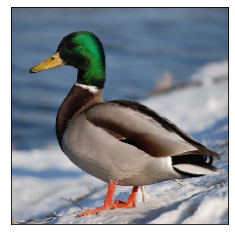

In [5]:
# Get the input image, in this case a duck, and prepare it for the network
duck_path = file_helper.get_input_file_path('duck-268105_640.jpg')
img = image.load_img(duck_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor /= 255
img_tensor = np.expand_dims(img_tensor, axis=0)
plt.imshow(img_tensor[0])
plt.xticks([],[])
plt.yticks([],[])
file_helper.save_figure('filter-responses-input')
plt.show()

In [6]:
# Get the output of every layer
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# A list of Numpy arrays, one array per layer activation
activations = activation_model.predict(img_tensor)

In [7]:
# This image might have a very wide range of values, so center them
# and scale by the standard deviation so that we see most of the values
def prep_image_for_display(input_image):
    image = np.copy(input_image)
    image -= image.mean()
    image /= (image.std() + 1e-5)
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype('uint8')
    return image

In [8]:
def show_activations(activations, activation_index, num_rows, num_cols, title):
    display_res = activations[activation_index][0].shape[1] # assume these are squares
    gap = max(1, int(.05 * display_res))
    grid = np.zeros(((display_res*num_rows)+(gap*(num_rows-1)), 
                     (display_res*num_cols)+(gap*(num_cols-1))))

    for y in range(num_rows):
        for x in range(num_cols):
            index = (y * num_cols) + x
            response = activations[activation_index][0, :, :, index]
            response = prep_image_for_display(response)
            h_start = x*(gap+display_res)
            v_start = y*(gap+display_res)
            grid[v_start : v_start+display_res, h_start : h_start+display_res] = response
    
    plt.figure(figsize=(num_cols, num_rows))
    plt.imshow(grid, interpolation='nearest', cmap='inferno')
    plt.title(title, fontsize=14, y=1.03)
    plt.tick_params(labelbottom='off', labelleft='off') 
    file_helper.save_figure('responses-'+title)
    plt.show()

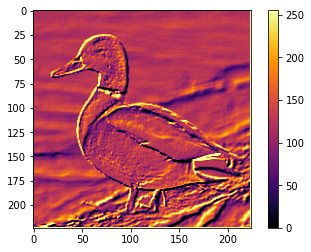

In [9]:
img = prep_image_for_display(activations[1][0, :, :, 0])
fig = plt.figure()
im = plt.imshow(img, cmap='inferno')
ax = fig.gca()
fig.colorbar(im, ax=ax)
plt.tick_params(labelbottom='off', labelleft='off') 
file_helper.save_figure('response-block1_conv1_filter0')
plt.show()

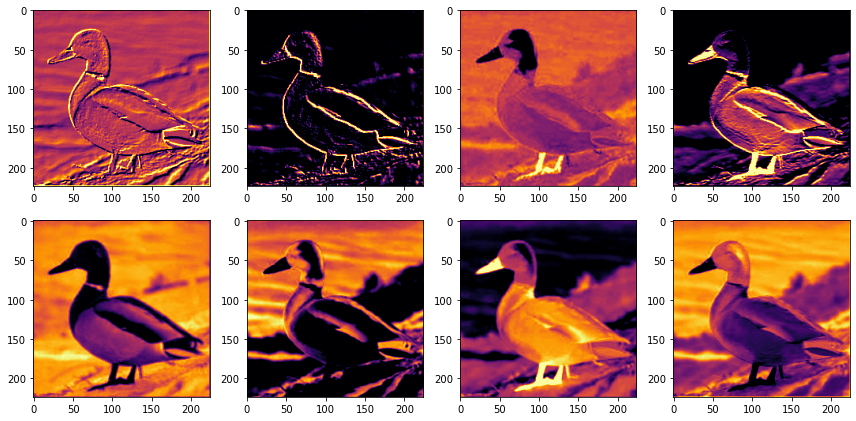

In [10]:
plt.figure(figsize=(12,6))
selects = [0, 6, 8, 9, 16, 19, 22, 29]
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = prep_image_for_display(activations[1][0, :, :, selects[i]])
    plt.imshow(img, cmap='inferno')
    plt.tick_params(labelbottom='off', labelleft='off') 
plt.tight_layout()
file_helper.save_figure('response-block1_conv1_filter-selections')
plt.show()

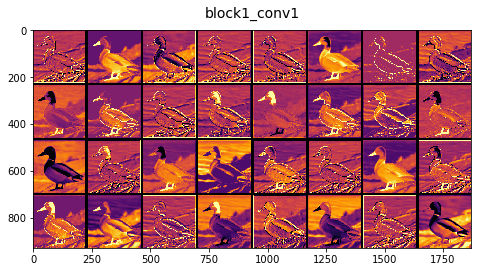

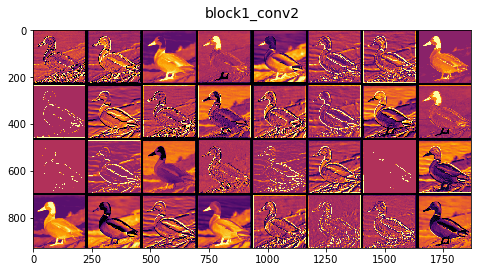

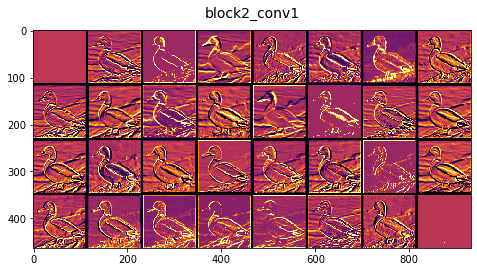

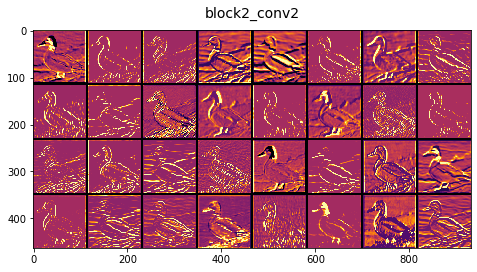

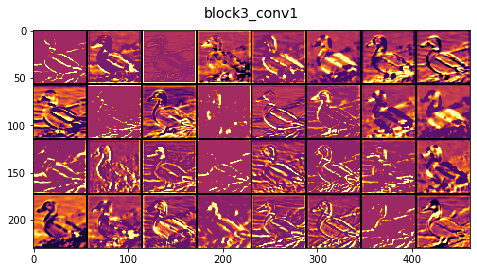

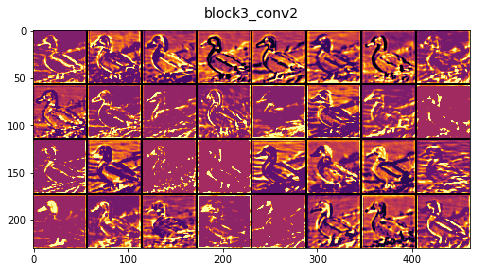

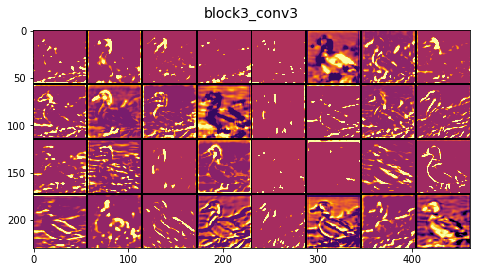

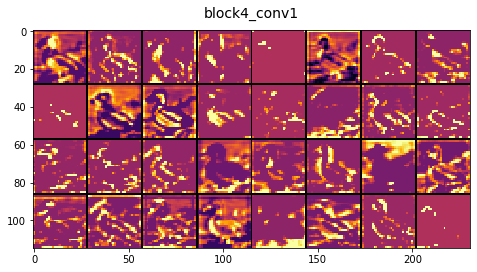

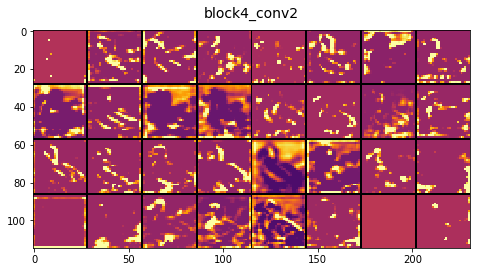

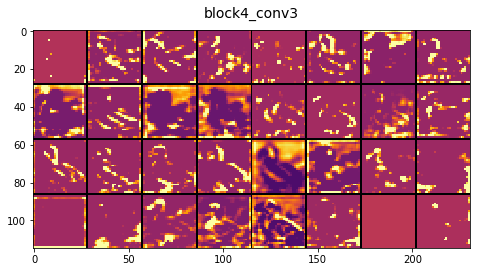

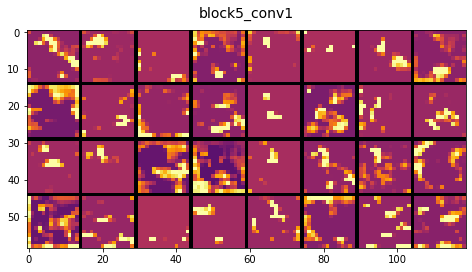

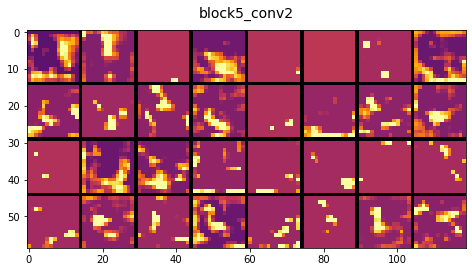

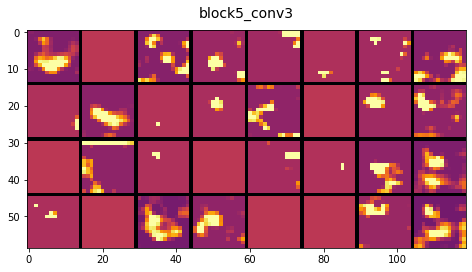

In [11]:
activation_sets = [
    [1, 4, 8, "block1_conv1"],
    [2, 4, 8, "block1_conv2"],
    [4, 4, 8, "block2_conv1"],
    [5, 4, 8, "block2_conv2"],
    [7, 4, 8, "block3_conv1"],
    [8, 4, 8, "block3_conv2"],
    [9, 4, 8, "block3_conv3"],
    [11, 4, 8, "block4_conv1"],
    [12, 4, 8, "block4_conv2"],
    [12, 4, 8, "block4_conv3"],
    [15, 4, 8, "block5_conv1"],
    [16, 4, 8, "block5_conv2"],
    [17, 4, 8, "block5_conv3"],
    ]
    
for aset in activation_sets:
    show_activations(activations, aset[0], aset[1], aset[2], aset[3])